In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install -q transformers[sentencepiece] fastai nbdev fastbook ohmeow-blurr

In [ ]:
from fastai.text.all import *
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
from blurr.text.data.all import *
from blurr.text.modeling.all import *
import pandas as pd

/usr/local/lib/python3.10/dist-packages/blurr/text/modeling/question_answering.py:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric("squad")


In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Projects/NLP Models

/content/drive/.shortcut-targets-by-id/1ijxO7bmhCZdrDAzQZnE4FZhf032K0Icj/Colab Projects/NLP Models


In [ ]:
%ls

data/                     story-genre-classifier.pkl
genre_types_encoded.json  story-genre-classifier-v0.pkl
models/


In [ ]:
df = pd.read_csv(r"/content/drive/MyDrive/Colab Projects/NLP Models/data/fiction_data_with_tags_and_cover_url.csv")

In [ ]:
df.head()

In [ ]:
df = df.drop(columns=['Cover_URL'])

In [ ]:
df = df.drop(columns=['Color Info'])

In [ ]:
df.shape

(55447, 3)

In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=8998eb63352774ebeb9c385b2ec4b8622e010f12a3eb01a54fffce1ffdf5c147
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
from langdetect import detect
import re

# Define a function to check if a description is in English
def is_english(description):
    try:
        lang = detect(description)
        return lang == 'en'
    except:
        return False

# Define a function to check if a description contains a reasonable amount of English words
def has_reasonable_english_words(description):
    english_words = re.findall(r'\b\w+\b', description)
    return len(english_words) > 5  # Adjust the threshold as needed

# Apply the functions to filter inaccurate descriptions
df['is_english'] = df['Description'].apply(lambda x: is_english(str(x)))
df['has_reasonable_english_words'] = df['Description'].apply(lambda x: has_reasonable_english_words(str(x)))

# Filter out inaccurate descriptions and keep only valid ones
filtered_df = df[(df['is_english'] == True) & (df['has_reasonable_english_words'] == True)]

# Drop the temporary columns
filtered_df = filtered_df.drop(columns=['is_english', 'has_reasonable_english_words'])

# Now 'filtered_df' contains descriptions that are likely to be accurate and in English

In [ ]:
def remove_non_letter_characters(text):
    # Define a regular expression pattern to match non-letter characters
    pattern = r'[^a-zA-Z\s]'
    # Replace non-letter characters with an empty string
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

# Apply the function to remove non-letter characters from the description
filtered_df['Description'] = filtered_df['Description'].apply(remove_non_letter_characters)

In [ ]:
filtered_df.shape

(54122, 3)

In [ ]:
df = filtered_df

In [ ]:
df

In [ ]:
df.to_csv("fiction data cleaned.csv")

In [ ]:
df = pd.read_csv(r"/content/drive/MyDrive/Colab Projects/NLP Models/data/fiction data cleaned.csv")

In [ ]:
# Creating a list of all tags
all_tags = [tag for tags_list in df['Tags'] for tag in tags_list]

# Creating a dictionary to count unique tags
tag_counts = {}

# Counting the occurrences of each tag
for tag in all_tags:
    if tag in tag_counts:
        tag_counts[tag] += 1
    else:
        tag_counts[tag] = 1

# Counting tags with more than 1000 occurrences
tags_over_1000_count = sum(1 for count in tag_counts.values() if count > 500)

# Printing the count of tags with more than 1000 occurrences
print("Number of tags with more than 1000 occurrences:", tags_over_1000_count)


Number of tags with more than 1000 occurrences: 51


In [ ]:
keyword_to_genre = {
    'Psychological Suspense': ['mind games', 'tension', 'unreliable narrator', 'paranoia', 'intrigue'],
    'Time-Travel Adventure': ['temporal journey', 'altered history', 'paradox', 'anachronism', 'time machine'],
    'War Epic': ['battlefield', 'heroism', 'conflict', 'sacrifice', 'triumph'],
    'Magical Realism': ['surreal', 'enchantment', 'everyday magic', 'dreamlike', 'symbolism'],
    'Romantic Comedy': ['love triangle', 'quirky romance', 'humor', 'misunderstandings', 'heartwarming'],
    'Space Exploration': ['astronauts', 'interstellar travel', 'discovery', 'alien worlds', 'cosmic adventure'],
    'Alternate History': ['what-if scenarios', 'historical divergence', 'altered events', 'counterfactual', 'butterfly effect'],
    'Historical Thriller': ['intrigue', 'suspicion', 'espionage', 'conspiracies', 'plot twists'],
    'Mythological Fantasy': ['gods and goddesses', 'legends', 'ancient prophecies', 'epic quests', 'mythical creatures'],
    'Superhero Adventure': ['powers', 'secret identity', 'justice', 'supervillains', 'vigilante'],
    'Cyberpunk Mystery': ['cyberpunk', 'high-tech', 'neon lights', 'techno-thriller', 'digital intrigue'],
    'Dystopian Romance': ['dystopia', 'romantic tension', 'resistance', 'oppression', 'forbidden love'],
    'Steampunk Adventure': ['steampunk', 'clockwork', 'airships', 'mechanical marvels', 'adventurous quests'],
    'Alien Encounter': ['aliens', 'first contact', 'extraterrestrial beings', 'intergalactic diplomacy', 'unknown worlds'],
    'Post-Apocalyptic Mystery': ['post-apocalyptic', 'mysterious ruins', 'survival', 'enigmatic artifacts', 'society collapse'],
    'Political Intrigue': ['politics', 'power struggles', 'diplomacy', 'conspiracy', 'government manipulation'],
    'Family Saga': ['family dynamics', 'generational saga', 'inheritance', 'interconnected lives', 'family secrets'],
    'Environmental Fiction': ['environmental issues', 'ecological balance', 'nature', 'human impact', 'eco-consciousness'],
    'Romantic Fantasy': ['romantic fantasy', 'enchanted worlds', 'magic', 'epic love story', 'mystical creatures'],
    'Mythical Adventure': ['mythical quest', 'legendary artifacts', 'heroic journey', 'mythical creatures', 'ancient lore'],
    'Spy Thriller': ['spies', 'covert operations', 'espionage', 'intelligence agencies', 'intrigue'],
    'Medical Drama': ['medical professionals', 'hospital life', 'healthcare challenges', 'life-and-death decisions', 'emotional toll'],
    'Legal Mystery': ['legal cases', 'courtroom drama', 'mystery-solving', 'legal procedures', 'crime and justice'],
    'Conspiracy Thriller': ['conspiracies', 'secret plots', 'cover-ups', 'political intrigue', 'unveiling the truth'],
    'Philosophical Fiction': ['philosophical ideas', 'existential dilemmas', 'ethical questions', 'introspection', 'deep contemplation'],
    'Religious/Spiritual': ['faith', 'spirituality', 'religious journey', 'divine intervention', 'spiritual awakening'],
    'Gothic Horror': ['gothic atmosphere', 'supernatural terror', 'haunted mansion', 'dark secrets', 'macabre'],
    'Historical Adventure': ['historical setting', 'adventurous quest', 'exploration', 'historical events', 'cultural exploration'],
    'Apocalyptic Fantasy': ['apocalyptic world', 'fantastical elements', 'heroes of destiny', 'struggle for survival', 'epic battles'],
    'Psychological Drama': ['psychological turmoil', 'emotional conflict', 'inner demons', 'human psyche', 'character introspection'],
    'Techno-Thriller': ['technology gone awry', 'high-tech danger', 'cyber threats', 'technological espionage', 'scientific suspense'],
    'Urban Fantasy Mystery': ['urban fantasy', 'mysterious occurrences', 'supernatural investigation', 'magic in the modern world', 'cryptic puzzles'],
    'Military Science Fiction': ['military operations', 'advanced weaponry', 'space warfare', 'battle strategies', 'intergalactic conflict'],
    'Time-Travel Romance': ['time-travel romance', 'love across time', 'temporal obstacles', 'romantic fate', 'heartfelt connections'],
    'Political Fantasy': ['political intrigue', 'fantasy world-building', 'power struggles', 'courtly machinations', 'royal politics'],
    'Humorous Mystery': ['humorous detective', 'comedic investigation', 'quirky sleuth', 'laugh-out-loud whodunit', 'mystery with a twist of humor'],
    'Sports Drama': ['sports competition', 'athletic challenges', 'personal growth', 'team dynamics', 'triumph over adversity'],
    'Young Adult Fantasy': ['young adult adventure', 'magical coming of age', 'fantasy realms', 'heroic destiny', 'teenage struggles'],
    'Robotic Adventure': ['robots', 'AI companions', 'mechanical allies', 'technological journey', 'human-robot interactions'],
    'Horror': ['horror', 'supernatural', 'terror', 'fear', 'haunting'],
    'Tragedy': ['tragedy', 'unfortunate events', 'heartbreaking', 'loss', 'suffering'],
    'Science Fiction': ['science fiction', 'futuristic technology', 'space exploration', 'aliens', 'time travel'],
    'Mystery': ['mystery', 'detective', 'whodunit', 'intrigue', 'puzzle'],
    'Adventure': ['adventure', 'exploration', 'quest', 'journey', 'treasure'],
    'Historical Fiction': ['historical fiction', 'period setting', 'historical events', 'authentic details', 'cultural norms'],
    'Comedy': ['comedy', 'humor', 'wit', 'funny', 'laughter'],
    'Drama': ['drama', 'emotional', 'conflict', 'character development', 'intense'],
    'Action': ['action', 'fast-paced', 'exciting', 'thrilling', 'combat'],
    'Fantasy': ['fantasy', 'magical', 'mythical creatures', 'epic quests', 'enchanted realms'],
    'Crime': ['crime', 'criminal underworld', 'law enforcement', 'investigation', 'crime solving'],
    'Romance': ['romance', 'love', 'heartfelt', 'passion', 'relationship', 'affection'],
    'Thriller': ['thriller', 'suspense', 'tension', 'intense', 'danger']
}


In [ ]:
def update_tags(description, tags):
    for genre, keywords in keyword_to_genre.items():
        for keyword in keywords:
            if keyword in description.lower():
                tags.append(genre)
    return tags


In [ ]:
df['Tags'] = df.apply(lambda row: update_tags(row['Description'], eval(row['Tags'])), axis=1)

<ipython-input-18-ad5bd4869704>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tags'] = df.apply(lambda row: update_tags(row['Description'], eval(row['Tags'])), axis=1)


In [ ]:
df.isnull().sum()

Title          0
Tags           0
Description    0
dtype: int64

In [ ]:
df = df.dropna(subset=['Description', 'Title'])

In [ ]:
df.head()

In [ ]:
type((df['Tags'][0]))

list

In [ ]:
# Create a list of tags from the 'Tags' column
tag_list = df['Tags'].to_list()

# Initialize a dictionary to count tag occurrences
tag_count = {}

# Iterate through each list of tags
for tags in tag_list:
    for tag in tags:
        # Increment tag count if it exists in the dictionary, otherwise initialize it to 1
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1

# Print the number of unique tags
print(f"Number of Unique Tags: {len(tag_count)}")


Number of Unique Tags: 103


In [ ]:
threshold = int(len(df) * 0.005)
rare_genres = [key for key, value in tag_count.items() if value < threshold]
len(rare_genres), rare_genres[:5]

(22,
 ['Cyberpunk Mystery',
  'Historical Adventure',
  'Romantic Comedy',
  'Apocalyptic Fantasy',
  'Conspiracy Thriller'])

In [ ]:
df.shape

(54117, 4)

In [ ]:
# Drop rows with empty records and reset the index
df = df.dropna(subset=['Title', 'Description', 'Tags'], how='any').reset_index(drop=True)

# Display the shape of the modified DataFrame
print(df.shape)


(54117, 4)


In [ ]:
# Create a list of tags from the 'Tags' column
tag_list = df['Tags'].to_list()

# Initialize a list to store revised genres
revised_genre_list = []

# Initialize a list to store indices of rows to drop
indices_to_drop = []

# Iterate through each list of genres
for idx, genres in enumerate(tag_list):
    # Convert the string of genres to a list
    genres_list = genres

    # Initialize a list to store revised genres for the current row
    revised_genres = []

    # Iterate through each genre in the list
    for genre in genres_list:
        if genre not in rare_genres:
            revised_genres.append(genre)

    # Check if the row has valid genres after revision
    if len(revised_genres) == 0:
        indices_to_drop.append(idx)
    else:
        revised_genre_list.append(revised_genres)

# Drop rows with no valid genres and reset the index
df = df.drop(indices_to_drop).reset_index(drop=True)

# Display the shape of the modified DataFrame
print("Shape of the Modified DataFrame:", df.shape)


Shape of the Modified DataFrame: (53860, 4)


In [ ]:
df

In [ ]:
df["Genres"] = revised_genre_list

In [ ]:
df.head()

In [ ]:
# Create a list of genres from the 'Genres' column
genre_list = df['Genres'].to_list()

# Initialize a dictionary to count genre occurrences
revised_genre_count = {}

# Iterate through each list of genres
for genres in genre_list:
    genres_list = genres
    for genre in genres_list:
        if genre in revised_genre_count.keys():
            revised_genre_count[genre] += 1
        else:
            revised_genre_count[genre] = 1

# Print the number of unique genres
print(f"Number of Unique Genres: {len(revised_genre_count)}")

# Display the revised genre count dictionary
print(revised_genre_count)

Number of Unique Genres: 81
{'Time Loop': 473, 'Adventure': 46520, 'Fantasy': 44534, 'Mystery': 6415, 'Magic': 25267, 'Romantic Fantasy': 7331, 'Science Fiction': 561, 'Comedy': 39675, 'Action': 36000, 'Thriller': 2919, 'LitRPG': 10867, 'Progression': 8503, 'Super Heroes': 1927, 'Male Lead': 25039, 'Sci-fi': 9639, 'Low Fantasy': 5226, 'School Life': 5322, 'Slice of Life': 7501, 'War Epic': 1653, 'Superhero Adventure': 3134, 'Anti-Hero Lead': 9888, 'Genetically Engineered': 1483, 'Strong Lead': 13336, 'Time Travel': 1343, 'Villainous Lead': 2360, 'Non-Human Lead': 7898, 'Secret Identity': 5198, 'Artificial Intelligence': 1990, 'Technologically Engineered': 1495, 'Urban Fantasy': 4421, 'Female Lead': 11442, 'Drama': 10228, 'Mythos': 4194, 'Soft Sci-fi': 3160, 'Supernatural': 14981, 'Alien Encounter': 380, 'Horror': 7734, 'Reincarnation': 8918, 'Cyberpunk': 1615, 'Dystopia': 1952, 'Strategy': 6717, 'GameLit': 5087, 'Portal Fantasy / Isekai': 8594, 'Xianxia': 2507, 'Romance': 16885, 'Marti

In [ ]:
encode_genre_types = { key: idx for idx, (key, value) in enumerate(revised_genre_count.items())}
with open("genre_types_encoded.json", "w") as fp:
  json.dump(encode_genre_types, fp)

In [ ]:
# We need this because for multilabel classification all genres have possibility to be present in the predictions
categorical_genre_list = []
revised_genres_list = df['Genres'].to_list()

for revised_genres in revised_genres_list:
  categorical_list = [0] * len(encode_genre_types)
  for genre in revised_genres:
    genre_type_index = encode_genre_types[genre]
    categorical_list[genre_type_index] = 1
  categorical_genre_list.append(categorical_list)

categorical_genre_list[3][:23]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]

In [ ]:
df['genre_cat_list'] = categorical_genre_list

Dataloaders and Models

In [ ]:
labels = list(encode_genre_types.keys())

In [ ]:
model_name = "distilbert-base-uncased"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

In [ ]:
!pip install ohmeow-blurr

In [ ]:
model_name = "roberta-base"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"


In [ ]:
model_name = "bert-base-uncased"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

In [ ]:
df.head()

In [ ]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded=True, vocab=labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader('Description'), get_y=ColReader('genre_cat_list'), splitter=RandomSplitter(valid_pct=0.1, seed=42))

In [ ]:
blocks = (
    TextBlock.from_df('Description', tok_text_col='Description', vocab=hf_tokenizer.get_vocab(), seq_len=512),
    MultiCategoryBlock(encoded=True, vocab=labels)
)
dblock = DataBlock(blocks=blocks, get_x=ColReader('Description'), get_y=ColReader('genre_cat_list'), splitter=RandomSplitter(valid_pct=0.1, seed=42))

In [ ]:
dls = dblock.dataloaders(df, bs=16)

In [ ]:
dls.vocab

['Time Loop', 'Adventure', 'Fantasy', 'Mystery', 'Magic', 'Romantic Fantasy', 'Science Fiction', 'Comedy', 'Action', 'Thriller', 'LitRPG', 'Progression', 'Super Heroes', 'Male Lead', 'Sci-fi', 'Low Fantasy', 'School Life', 'Slice of Life', 'War Epic', 'Superhero Adventure', 'Anti-Hero Lead', 'Genetically Engineered', 'Strong Lead', 'Time Travel', 'Villainous Lead', 'Non-Human Lead', 'Secret Identity', 'Artificial Intelligence', 'Technologically Engineered', 'Urban Fantasy', 'Female Lead', 'Drama', 'Mythos', 'Soft Sci-fi', 'Supernatural', 'Alien Encounter', 'Horror', 'Reincarnation', 'Cyberpunk', 'Dystopia', 'Strategy', 'GameLit', 'Portal Fantasy / Isekai', 'Xianxia', 'Romance', 'Martial Arts', 'High Fantasy', 'Multiple Lead Characters', 'Historical', 'Satire', 'War and Military', 'Psychological', 'Ruling Class', 'First Contact', 'Virtual Reality', 'Grimdark', 'Attractive Lead', 'Post Apocalyptic', 'Post-Apocalyptic Mystery', 'Contemporary', 'Wuxia', 'Psychological Suspense', 'Historica

In [ ]:
dls.show_batch(dataloaders=dls, max_n=4, trunc_at=512)

,text,target
0,siang fasa completely made up name on the spot has always felt as though nothing truly existed when he was young he didnt really think at all he just enjoyed life as a silly little child he only started thinking about things when his family moved to a different city he tried making freinds with the other kids at school but something was weird about them they were always talking to each other always playing around with others always making others into jokes as they try to look cool or impress their girl with,"[Adventure, Fantasy, Comedy, Action, Supernatural, Romance, Martial Arts, Psychological, Tragedy, Reader Interactive]"
1,frith is lost in the reincarnation process of souls lost in purgatory found and given the chance that is only given to those chosen few of gods a new start a new body a new existence of pure infinite possibility where any can become the strong the fragments of his broken mind tell him little of who he was before but the goddess that came and restores his mind ended his eternal torment of the endless void a hopeless existence and a soul destroyed by silence and nothingness is given hope and wonders his exist,"[Adventure, Fantasy, Magic, Comedy, Action, LitRPG, Progression, Male Lead, Anti-Hero Lead, Non-Human Lead, Reincarnation, Strategy, Martial Arts, Multiple Lead Characters, War and Military, Psychological Suspense]"
2,a new breed of humans have started to awaken to their evolution experiencing a trigger that hastened them to advance sooner than most normal humans they are called accelerators individuals who went through a physical or mental metamorphosis that separated them from the ordinary they harbor special skills and unique abilities to use at will their numbers have slowly increased over the years those who were discovered were registered in the government and had their lives changed in the consequence those who fe,"[Fantasy, Comedy, Action, Sci-fi, School Life, Supernatural, Horror]"
3,this is a work of fantasy as such it is also uncomplete all rights reserved to the author and the authour may change this work to suite their intrests note do not take this synopsis seriously this work is unfinished and a true synopsis will be written if and when the authour deems that this work is complete look around now child see those statues over younder i said to my son pointing at those frightened forms aye papa my son said with wonder in his eyes papa why do they look so scared was the sculpter tryi,"[Adventure, Fantasy, Magic, Comedy, Action, Low Fantasy, Drama, Mythos, Horror, High Fantasy, Multiple Lead Characters, War and Military, Grimdark, Post-Apocalyptic Mystery, Environmental Fiction]"


In [ ]:
model = BaseModelWrapper(hf_model)

acc_02 = partial(accuracy_multi, thresh=0.2)

learner = Learner(dls,
                  model,
                  opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                  loss_func=BCEWithLogitsLossFlat(),
                  metrics=[acc_02],
                  cbs=[BaseModelCallback],
                  splitter=blurr_splitter
                  ).to_fp16()

In [ ]:
# Create a model wrapper for the HF model
model = BaseModelWrapper(hf_model)

# Define a partial function for multi-label accuracy with threshold of 0.2
acc_02 = partial(accuracy_multi, thresh=0.2)

# Create a Learner instance with the specified settings
learner = Learner(
    dls,                           # DataLoaders
    model,                         # Model wrapper
    opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),  # Optimizer wrapper
    loss_func=BCEWithLogitsLossFlat(),                      # Loss function
    metrics=[acc_02],              # Evaluation metric
    cbs=[BaseModelCallback],       # Callbacks (if any)
    splitter=blurr_splitter        # Splitter function (if needed)
).to_fp16()                       # Use mixed-precision training if available


Stage 0

In [ ]:
learner.freeze()

SuggestedLRs(slide=0.00363078061491251, valley=0.0003981071640737355)

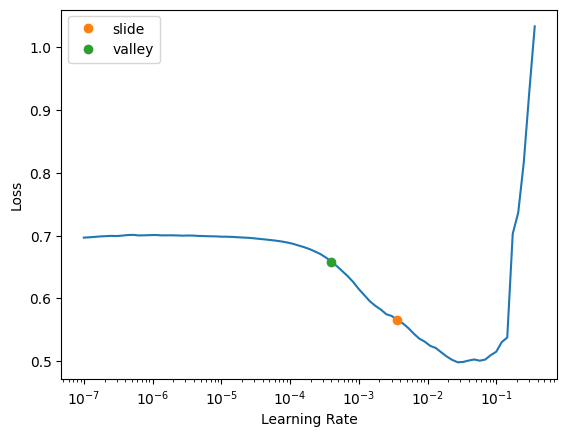

In [ ]:
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
import math

slide = 0.00363078061491251
valley = 0.0003981071640737355

log_slide = math.log10(slide)
log_valley = math.log10(valley)

lr_max = slice(10**(log_valley), 10**(log_slide))

lr_max

slice(0.0003981071640737355, 0.0036307806149125104, None)

In [ ]:
learner.fit_one_cycle(2, lr_max = lr_max)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.242335,0.237556,0.864677,05:24
1,0.232891,0.229386,0.868801,05:29


Stage 1

In [ ]:
learner.unfreeze()

SuggestedLRs(slide=0.004365158267319202, valley=2.75422871709452e-06)

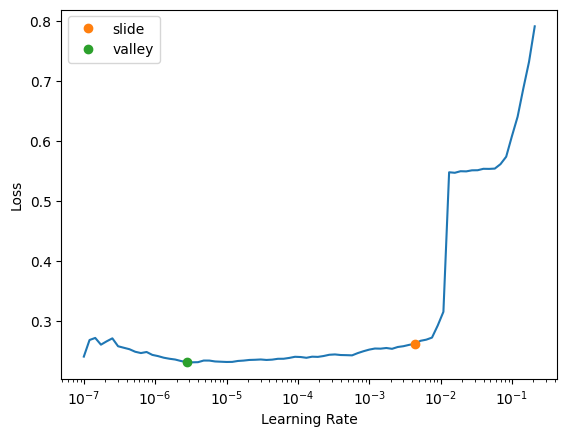

In [ ]:
from fastai.callback.schedule import slide, valley

learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
slide = 0.004365158267319202
valley = 2.75422871709452e-06

log_slide = math.log10(slide)
log_valley = math.log10(valley)

lr_max = slice(10**(log_valley), 10**(log_slide))

lr_max

slice(2.7542287170945176e-06, 0.004365158267319202, None)

In [ ]:
learner.fit_one_cycle(5, lr_max = lr_max)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.227992,0.221843,0.855911,08:28
1,0.213423,0.212229,0.885165,08:30
2,0.200812,0.208593,0.891506,08:29
3,0.192669,0.207424,0.883910,08:30
4,0.171018,0.212532,0.881160,08:30


In [ ]:
learner.save("story-genre-classifier")

Path('models/story-genre-classifier.pth')

In [ ]:
learner.export("story-genre-classifier-v1.pkl")